# Combined CCLE Model Training

This notebook combines the CCLE gene expression dataset with dynamic features and then is trained together

## Initialisation

In [1]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Users\dawson\Documents\GitHub\ode-biomarker-project


In [2]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [3]:
# load in dynamic features data 
loading_code = 'generic-gdsc-1-FGFR_0939-LN_IC50-fgfr4_ccle_dynamic_features_v2-true-Unnamed: 0'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
dynamic_feature_data, dynamic_label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {dynamic_feature_data.shape} Label Shape {dynamic_label_data.shape}')

# load in ccle static gene expression data
loading_code = 'ccle-gdsc-1-FGFR_0939-LN_IC50'
feature_data, label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {feature_data.shape} Label Shape {label_data.shape}')

Data loaded for code generic-gdsc-1-FGFR_0939-LN_IC50-fgfr4_ccle_dynamic_features_v2-true-Unnamed: 0 Feature Shape (665, 260) Label Shape (665,)
Data loaded for code ccle-gdsc-1-FGFR_0939-LN_IC50 Feature Shape (667, 19221) Label Shape (667,)


In [4]:
from toolkit import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
folder_name = "FGFR4-combined-model-training"
exp_id = "fgfr4_v1"
fixed_random_seed = 42 # -1 for no seed
save_figure = False
save_data = True
show_figure = False

all_models = ['SVR', 'RandomForestRegressor', 'XGBRegressor', 'MLPRegressor', 'KNeighborsRegressor', 'ElasticNet']

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

In [6]:
# remove samples present in feature data but not in dynamic feature data
new_feature_data = feature_data.loc[feature_data.index.isin(dynamic_feature_data.index)]
new_label_data = label_data.loc[label_data.index.isin(dynamic_feature_data.index)]

# check size 
print(new_feature_data.shape)
print(new_label_data.shape)

(665, 19221)
(665,)


In [7]:
combined_feature_data = pd.concat([new_feature_data, dynamic_feature_data], axis=1)
combined_label_data = new_label_data

In [8]:
combined_feature_data

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,amTORC2_auc,amTORC2_median,amTORC2_tfc,amTORC2_tmax,amTORC2_max,amTORC2_tmin,amTORC2_min,amTORC2_ttsv,amTORC2_tsv,amTORC2_init
SIDM01132,3.955127,1.416840,6.620293,2.000000,3.333424,0.014355,5.654779,0.028569,2.726831,4.061776,...,0.001622,0.001435,1.732396,0.96,0.003096,0.0,0.001133,0.04,0.001133,0.001133
SIDM00848,4.247928,0.000000,6.174127,2.316146,3.823749,0.189034,1.321928,3.536053,3.943921,4.468583,...,0.463970,0.483035,0.281069,0.96,0.544116,0.0,0.424736,0.04,0.424736,0.424736
SIDM01111,4.327687,0.070389,5.979111,2.906891,4.904484,0.263034,2.235727,0.422233,4.432959,5.139961,...,0.073737,0.076469,0.295231,0.96,0.088013,0.0,0.067951,0.04,0.067951,0.067951
SIDM00909,3.264536,0.000000,6.096557,2.518535,3.040892,0.000000,0.831877,6.575615,4.656496,4.738768,...,0.042001,0.043628,0.375213,0.96,0.051130,0.0,0.037180,0.04,0.037180,0.037180
SIDM00807,5.128871,0.000000,6.691534,2.010780,4.976364,0.163499,1.636915,6.193575,3.505891,3.709291,...,0.153621,0.159928,0.308393,0.96,0.181684,0.0,0.138860,0.04,0.138860,0.138860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM00217,4.489286,0.475085,6.759955,2.451541,3.305971,1.464668,0.056584,5.996615,5.134221,4.635754,...,0.015140,0.015568,0.485826,0.96,0.019511,0.0,0.013131,0.04,0.013131,0.013131
SIDM00214,4.628190,0.298658,5.996615,4.042644,4.784504,0.042644,1.761285,5.067811,5.783457,4.943453,...,0.001227,0.001096,2.566311,0.96,0.002511,0.0,0.000704,0.04,0.000704,0.000704
SIDM00194,4.229588,0.014355,6.664767,2.691534,3.454176,0.042644,0.739848,6.417009,4.442943,2.959770,...,0.059500,0.061853,0.369219,0.96,0.072176,0.0,0.052713,0.04,0.052713,0.052713
SIDM00193,3.477677,0.000000,6.385949,3.570463,3.232661,0.000000,0.275007,6.417515,6.407013,3.727920,...,0.046056,0.047720,0.353875,0.96,0.056037,0.0,0.041390,0.04,0.041390,0.041390


In [9]:
def pipeline_func(X_train, y_train, rng, model_used, **kwargs):
    k = X_train.shape[1]
    if k > 500: 
        k = 500 # limit the number of features to 500
    selected_features, scores = f_regression_select(X_train, y_train, k)
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    # print(f'{rng} {model_used}')
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}


def eval_func(X_test, y_test, pipeline_components=None, **kwargs):
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp}

def eval_func_best(X_test, y_test, pipeline_components=None, **kwargs):
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp, 'y_test': y_test, 'y_pred': y_pred}

## Negative Control (random data)

In [10]:
# generate a random dataset for testing
import numpy as np

# set random seed
np.random.seed(42)

X = np.random.rand(1000, 500)
y = np.random.rand(1000)

X = pd.DataFrame(X)
y = pd.Series(y)

In [11]:
powerkit = Powerkit(X, y)
rngs = list(range(100))

In [12]:
for model_used in all_models:
    powerkit.add_condition(model_used, False, pipeline_func, {'model_used': model_used}, eval_func, {})

In [13]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, 16, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_control_negative.pkl')

Running SVR...
Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Positive Control (make_regression data)

To ensure all models are working as intended

### Training

In [14]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=1000, n_features=500, noise=0.1)
# make X,y into dataframes
X = pd.DataFrame(X)
y = pd.Series(y)

In [15]:
powerkit = Powerkit(X, y)
rngs = list(range(100))

In [16]:
for model_used in all_models:
    powerkit.add_condition(model_used, False, pipeline_func, {'model_used': model_used}, eval_func, {})

In [17]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, 16, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_control_positive.pkl')

Running SVR...
Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


### Visualisation

In [ ]:
import pickle 

df_list = []
for model_used in all_models:
    df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_control_positive.pkl')
    df_list.append(df)


In [ ]:
df_list[4]

In [ ]:
# join all the dataframes
df_all = pd.concat(df_list, axis=0)
df_all.head()

In [ ]:
from Visualisation import plot_box_plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

fig, ax = plt.subplots(figsize=(16, 8))
plot_box_plot(df_all, 'condition', 'model_performance', 'Model Performance', 'Model'
              ,'Pearson Correlation', ax=ax, tick_fontsize=16)


In [ ]:
# check the best model for each model category 
best_models = df_all.groupby('condition')['model_performance'].idxmax()

In [ ]:
best_models

In [ ]:
# for each best performing model, re-run the pipeline and plot model results
for model_used in all_models:
    powerkit.add_condition(f'{model_used}_best', False, pipeline_func, {'model_used': model_used}, eval_func_best, {})

    

In [ ]:
df_list = []
for model_used in all_models:
    print(f'Running {model_used}...')
    best_rng = df_all.loc[best_models[model_used]]['rng'].values[0]
    print(best_rng, model_used)
    # run pipeline with best rng
    df = powerkit.run_selected_condition(f'{model_used}_best', [best_rng], 1, True)
    df_list.append(df)

In [ ]:
import math

plot_cols = 3
plot_rows = math.ceil(len(df_list)/plot_cols)
plt.subplots(plot_rows, plot_cols, figsize=(5*plot_cols, 4*plot_rows))

normalise = True

for i, df in enumerate(df_list):
    plt.subplot(plot_rows, plot_cols, i+1)
    # get y_test and y_pred
    y_test = df['y_test'].values[0]
    y_pred = df['y_pred'].values[0]
    model_used = df['condition'].values[0].split('_')[0]
    if normalise:
        y_test = (y_test - y_test.mean()) / y_test.std()
        y_pred = (y_pred - y_pred.mean()) / y_pred.std()
    # plot y_test vs y_pred
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')
    plt.title(f'{model_used}')
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    plt.text(0.1, 0.9, f'Corr: {corr:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.text(0.1, 0.8, f'p: {p_vals:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
    # plot y=x line
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.grid()


plt.tight_layout()
plt.show()

In [ ]:
df_all

## Positive Control (CCLE Only)

In [18]:
powerkit = Powerkit(new_feature_data, new_label_data)
rngs = list(range(100))

In [19]:
for model_used in all_models:
    powerkit.add_condition(model_used, True, pipeline_func, {'model_used': model_used}, eval_func, {})

In [20]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, 16, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_control_ccle.pkl')

Running SVR...
Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Positive Control 2 (Dynamic Features Only)

In [21]:
powerkit = Powerkit(dynamic_feature_data, dynamic_label_data)
rngs = list(range(100))

In [22]:
for model_used in all_models:
    powerkit.add_condition(model_used, True, pipeline_func, {'model_used': model_used}, eval_func, {})

In [23]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, 16, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_control_dynamic.pkl')

Running SVR...
Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Combined (CCLE + Dyn)

In [24]:
powerkit = Powerkit(combined_feature_data, combined_label_data)
rngs = list(range(100))

In [25]:
for model_used in all_models:
    powerkit.add_condition(model_used, True, pipeline_func, {'model_used': model_used}, eval_func, {})

In [26]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, 16, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_combined.pkl')

Running SVR...
Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Visualise all results 

In [29]:
experiments = ['control_negative', 'control_positive', 'control_ccle', 'control_dynamic', 'combined']

import pickle 


df_list_total = []
for exp in experiments:
    df_list = []
    for model_used in all_models:
        df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_{exp}.pkl')
        print(f'Loaded {model_used} for {exp}')
        df_list.append(df)

    # join all the dataframes
    df_all = pd.concat(df_list, axis=0)
    df_all['experiment'] = exp
    df_list_total.append(df_all)
    
total_df = pd.concat(df_list_total, axis=0)
total_df

Loaded SVR for control_negative
Loaded RandomForestRegressor for control_negative
Loaded XGBRegressor for control_negative
Loaded MLPRegressor for control_negative
Loaded KNeighborsRegressor for control_negative
Loaded ElasticNet for control_negative
Loaded SVR for control_positive
Loaded RandomForestRegressor for control_positive
Loaded XGBRegressor for control_positive
Loaded MLPRegressor for control_positive
Loaded KNeighborsRegressor for control_positive
Loaded ElasticNet for control_positive
Loaded SVR for control_ccle
Loaded RandomForestRegressor for control_ccle
Loaded XGBRegressor for control_ccle
Loaded MLPRegressor for control_ccle
Loaded KNeighborsRegressor for control_ccle
Loaded ElasticNet for control_ccle
Loaded SVR for control_dynamic
Loaded RandomForestRegressor for control_dynamic
Loaded XGBRegressor for control_dynamic
Loaded MLPRegressor for control_dynamic
Loaded KNeighborsRegressor for control_dynamic
Loaded ElasticNet for control_dynamic
Loaded SVR for combined
Lo

,rng,condition,model_performance,p_vals,experiment,feature_importance
0,0,SVR,-0.057547,0.569555,control_negative,NaN
1,1,SVR,0.024277,0.810525,control_negative,NaN
2,2,SVR,-0.049221,0.626743,control_negative,NaN
3,3,SVR,-0.070793,0.483982,control_negative,NaN
4,4,SVR,0.032486,0.748320,control_negative,NaN
...,...,...,...,...,...,...
95,95,ElasticNet,0.397787,0.000858,combined,"([ENPP4, CD99, TSPOAP1, ANLN, ALOX5, SLC25A39,..."
96,96,ElasticNet,0.285729,0.019085,combined,"([ENPP4, CD99, TSPOAP1, CEACAM7, ANLN, DCN, AL..."
97,97,ElasticNet,0.503755,0.000014,combined,"([ENPP4, CD99, TSPOAP1, CEACAM7, ANLN, ALOX5, ..."
98,98,ElasticNet,0.409826,0.000573,combined,"([ENPP4, ICA1, PRSS22, CEACAM7, PLEKHG6, ALOX5..."


21.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
47.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


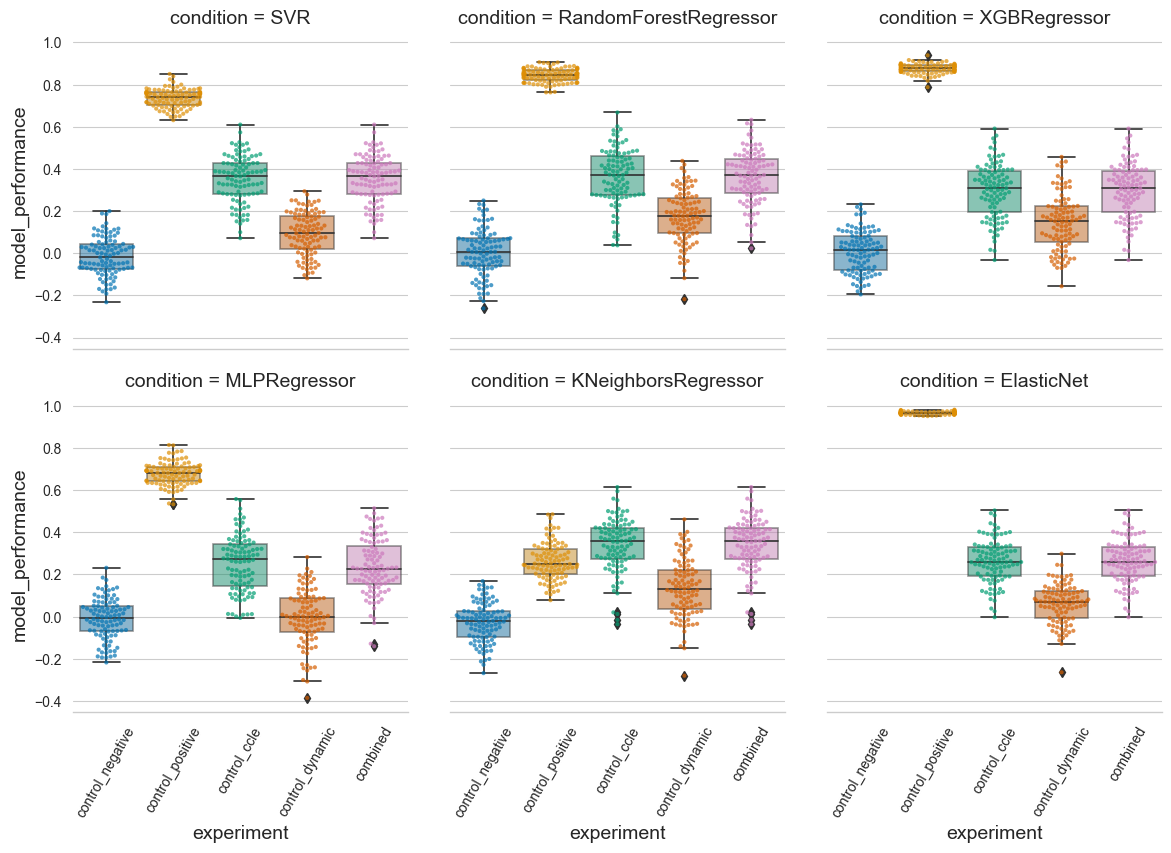

In [30]:
import seaborn as sns
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":14,"axes.labelsize":14, 'xtick.labelsize': 10, 'ytick.labelsize': 10}) 
sns.set_style("whitegrid")
sns.set_palette("colorblind")



g = sns.catplot(
    data=total_df, x="experiment", y="model_performance", col="condition",
    kind="box", height=4, aspect=1, sharey=True, sharex=True, col_wrap=3,
    boxprops=dict(alpha=.5),
)
g.set_xticklabels(rotation=60)
for ax in g.axes.flat:
    # ax.axhline(0, color='black', linestyle='--')
    condition_df = total_df[total_df['condition'] == ax.title.get_text().split('=')[1].strip(' ')]
    # print(ax.title.get_text().split('=')[1].strip(' '))
    sns.swarmplot(data=condition_df, x="experiment", y="model_performance", alpha=0.7, ax=ax, size=3)
    
g.despine(left=True)
plt.show()